## Population-level analysis of TMS-evoked spectral power: Windowed tapers
Loads preprocessed data from multi_file_preprocess and single_file_preprocess.ipynb
* Note: Subject 416 has separate elecs file for the second parietal stim session

In [3]:
import numpy as np
import mne
from glob import glob
import pandas as pd
import pylab as plt

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib')
from codebase import good_subs, target_dict

### Single-window power estimations for population-level analysis
Strategy: Similar to Solomon et al. 2021 (Brain Stim), measure stim vs sham t-stat for ~1 second windows (perhaps +500ms offset from stimulation) and visualize results across the population. Use LMM to analyze for population-level effect.

In [4]:
import pandas as pd
from mne.time_frequency import psd_array_multitaper
from scipy.stats import ttest_ind
from codebase import get_window_power

import warnings
warnings.filterwarnings("ignore")  # using this for a really dumb deprecation warning, nothing dangerous is happening

res = pd.DataFrame() # for storing our outputs

# Set some params
fs = 500 #saved data is all 500Hz sampling rate
freqs = [3, 8]
start_time = 1.1 # in seconds
win_size = 1.0 # in seconds
subtract_baseline = True
baseline_start = 0; baseline_win = 0.45 # for subtracting off baseline power

for sub in ['559']:
#for sub in list(good_subs.keys()): #loop through subjects
    for sess in good_subs[sub]:  #loop through stim sites/sessions

        # Load the data
        tms_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_TMS_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')  # using the -0.5 to 2 second files
        sham_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_Sham_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled.npy')
        elecs = pd.read_pickle('./TMSEEG_data/'+sub+'/'+sub+'_'+sess+'_elecs.pkl')
        
        # Get target electrode/coordinates
        target_channel = target_dict[sub][sess][-1]
        target_xyz = np.array(target_dict[sub][sess][0:3])
        
        ## TMS epochs ##
        psd_tms, freqs_used = get_window_power(tms_dat, fs=fs, start_time=start_time, win_size=win_size, freqs=freqs, n_cpus=n_cpus)  #output is trials x chans, averaging over frequencies
    
        ## Sham epochs ##
        psd_sham, freqs_used = get_window_power(sham_dat, fs=fs, start_time=start_time, win_size=win_size, freqs=freqs, n_cpus=n_cpus)
        
        if subtract_baseline:
            psd_tms_baseline, bs_freqs_used = get_window_power(tms_dat, fs=fs, start_time=baseline_start, win_size=baseline_win, freqs=freqs, n_cpus=n_cpus)
            psd_sham_baseline, _ = get_window_power(sham_dat, fs=fs, start_time=baseline_start, win_size=baseline_win, freqs=freqs, n_cpus=n_cpus)
            
            psd_tms = psd_tms-psd_tms_baseline
            psd_sham = psd_sham-psd_sham_baseline
        
        # Get TMS vs Sham T-statistic
        t, p = ttest_ind(psd_tms, psd_sham, axis=0, equal_var=False)
        
        # Remove saturated electrodes (thresholding the TEPs)
        from codebase import get_saturated_elecs
        sat_elecs = get_saturated_elecs(tms_dat, samples=250, thresh_=2)
        
        for idx in range(len(t)): #loop through electrodes
            elec_dict = dict(elecs.iloc[idx])  # harvest electrode information
            
            # Flag saturated electrodes
            if idx in sat_elecs:
                sat_flag=True
            else:
                sat_flag=False
                
            # Get Euclidean distance to stim site
            elec_xyz = np.array(elecs.iloc[idx][['anatX', 'anatY', 'anatZ']])
            euc_dist = np.linalg.norm(target_xyz-elec_xyz)
            if euc_dist<77.7:
                distance_category = 'close'
            elif (euc_dist>77.7) & (euc_dist<105.11):
                distance_category = 'middle'
            else:
                distance_category = 'far'
            
            mydict = {'subject': sub, 'session': sess, 'elec_idx': idx, 'T': t[idx], 'pval': p[idx], 
                     'powers_tms': psd_tms[:, idx], 'powers_sham': psd_sham[:, idx], 'saturated': sat_flag,
                     'target_channel': target_channel, 'target_x': target_xyz[0], 'target_y': target_xyz[1], 
                     'target_z': target_xyz[2], 'target_distance': euc_dist, 'distance_category': distance_category}
            mydict.update(elec_dict)
            
            # Update the DataFrame
            res = res.append(mydict, ignore_index=True)
    print(sub)

559


#### Remove possible artifactual responses
Despite this being "cleaned" data, some amplifier saturation does occur

In [325]:
# Simplest method: apply a T-value threshold (only expect this in the positive direction)
# res = res[res['T']<5]

# Alternate method: Measure the TEP for each electrode and set a t-value threshold
# This will do a good job capturing the saturated channels (e.g. sub 559, elec 62; sub 561, elec 195)
res = res[res['saturated']==False]

# Yet another method: Ensure that stimulated electrodes are excluded from analysis

# Remove epileptogenic electrodes
res = res[res['Seizure_Exclude']==0]

# Z-score the target distances for linear modeling
from scipy.stats import zscore
res['target_distance'] = zscore(res['target_distance'])

**Linear mixed effects analysis**

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T         
No. Observations: 2615    Method:             ML        
No. Groups:       13      Scale:              0.6809    
Min. group size:  102     Log-Likelihood:     -3239.1163
Max. group size:  417     Converged:          Yes       
Mean group size:  201.2                                 
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.128     0.081  1.585  0.113  -0.030   0.286
g1 Var      0.124     0.051                              



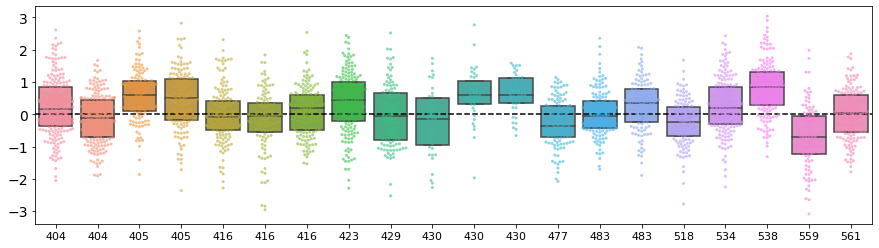

In [326]:
from utils import swarmplot_subjects
import statsmodels.api as sm
import seaborn as sns

# Need to drop some electrodes with NaNs (small amount of source EEG data contaminated with NaNs)
res_dropna = res.dropna(subset='T')

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(session)'}
model = sm.MixedLM.from_formula("T ~ 1", data=res_dropna, 
                               vc_formula=vcf,
                               groups='subject')
result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(res_dropna, key='T')
plt.figure(figsize=(15, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, alpha=0.6)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
#plt.savefig('./TMSEEG_plots/LMM_distribution_plot_gamma_1.1_2.1sec.pdf')

Looks like there is not a significant population-level effect. However, possible this would manifest with more data. 

Do the number of electrodes with a positive response exceed the number expected by chance? (assuming independence of electrodes?)

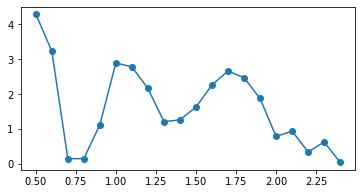

In [206]:
ts = [4.29, 3.23, 0.147, 0.15, 1.12, 2.892, 2.78, 2.16, 1.21, 1.26, 1.629, 2.26, 2.66, 2.47, 1.873, 0.785, 0.938, 0.340, 0.628, 0.042]
x = np.arange(0.5, 2.5, 0.1)

plt.figure(figsize=(6, 3))
plt.plot(x, ts, 'o-')

In [293]:
sig_elecs = res[res['pval']<0.05]  # can use a t-value threshold to determine "significance"

from scipy.stats import binom_test
p = binom_test(len(sig_elecs), len(res), 0.05, alternative='greater')  # binomial test for significance given chance probability of 0.05 that an electrode is significant. 
print('Binomial test: '+str(p))

Binomial test: 0.4770387662773546


By this measure, there is a significant population-level effect. 

Given a particular stim location, do we see a significant response? If so, where does that response manifest most strongly? 

In [61]:
def sig_elecs_by_region(df, p=0.05, ct_thresh=10): 
    '''
    Computes the number of significant response electrode by DKT region
    
    p: threshold for significant response electrode
    ct_thresh: threshold for total number of electrodes to consider a region in the analysis (default 10)
    '''

    # Create dictionary to look up total electrode counts for each response region
    region, counts = np.unique(df['DKT_label'], return_counts=True)
    df_dict = {}
    for idx, r in enumerate(region):
        df_dict[r] = counts[idx]

    # Compare significant electrode count to total counts, for any region with at least 10 electrodes
    df_sig_elecs = df[df['pval']<0.05]
    region, counts = np.unique(df_sig_elecs['DKT_label'], return_counts=True)
    perc_sig = {}
    for idx, r in enumerate(region):
        if df_dict[r]<ct_thresh:
            continue
        else:
            perc_sig[r] = np.round(float(counts[idx])/df_dict[r], decimals=4)
            
    return perc_sig, df_dict

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T         
No. Observations: 988     Method:             REML      
No. Groups:       8       Scale:              0.9787    
Min. group size:  39      Log-Likelihood:     -1397.6258
Max. group size:  178     Converged:          Yes       
Mean group size:  123.5                                 
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.031     0.061  0.515  0.606  -0.088   0.150
g1 Var      0.021     0.015                              



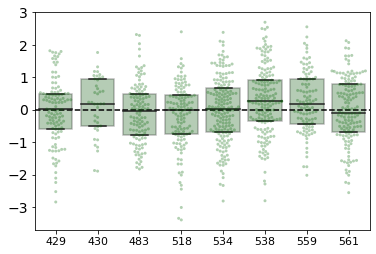

In [220]:
# What about for a certain stim location?

dlpfc_res = res_dropna[res_dropna['session'].str.contains('DLPFC')]

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(session)'}
# model = sm.MixedLM.from_formula("T ~ 1 + C(distance_category, Treatment(2))", data=dlpfc_res, 
#                                 vc_formula=vcf,
#                                 groups='subject')
model = sm.MixedLM.from_formula("T ~ 1", data=dlpfc_res, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=True)
print(result.summary())

#dlpfc_region, _ = sig_elecs_by_region(dlpfc_res)
#dlpfc_region

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(dlpfc_res, key='T')
plt.figure(figsize=(6, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, color='darkgreen', alpha=0.3)
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkgreen', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);

See whether response/sense region matters: 

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T         
No. Observations: 854     Method:             ML        
No. Groups:       5       Scale:              0.9959    
Min. group size:  121     Log-Likelihood:     -1214.5643
Max. group size:  268     Converged:          Yes       
Mean group size:  170.8                                 
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.102     0.073  1.386  0.166  -0.042   0.245
g1 Var      0.025     0.019                              



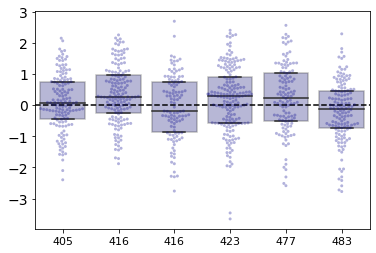

In [221]:
# Find the area with the strongest response (greatest numer of significant electrodes, proportionally)
parietal_res = res_dropna[res_dropna['session'].str.contains('Parietal')]

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(session)'}

# Including a categorical distance factor
model_distance = sm.MixedLM.from_formula("T ~ 1 + C(distance_category, Treatment(2))", data=parietal_res, 
                                vc_formula=vcf,
                                groups='subject')

# Intercept-only model
model = sm.MixedLM.from_formula("T ~ 1", data=parietal_res, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=False)
print(result.summary())

parietal_region, _ = sig_elecs_by_region(parietal_res)
parietal_region

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(parietal_res, key='T')
plt.figure(figsize=(6, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, color='darkblue', alpha=0.3)
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkblue', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T        
No. Observations: 495     Method:             ML       
No. Groups:       3       Scale:              0.8666   
Min. group size:  135     Log-Likelihood:     -670.6889
Max. group size:  211     Converged:          Yes      
Mean group size:  165.0                                
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.172     0.147  1.170  0.242  -0.116   0.461
g1 Var     0.060     0.057                              



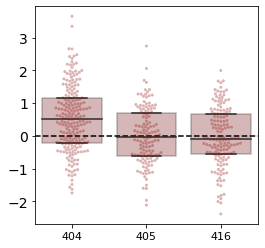

In [222]:
stg_res = res_dropna[(res_dropna['session'].str.contains('STG'))]

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(session)'}

# Including a categorical distance factor
model_distance = sm.MixedLM.from_formula("T ~ 1 + C(distance_category, Treatment(2))", data=stg_res, 
                                vc_formula=vcf,
                                groups='subject')

# Intercept-only model
model = sm.MixedLM.from_formula("T ~ 1", data=stg_res, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=False)
print(result.summary())

#stg_region, stg_dict = sig_elecs_by_region(stg_res, ct_thresh=5)
#stg_region

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(stg_res, key='T')
plt.figure(figsize=(4, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, color='darkred', alpha=0.3)
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkred', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);

Interesting! There seems to be a pretty robust theta response in the hippocampus to STG stimulation (but only 3 subjects got STG stim). 

### Is there a distance interaction?
Does stimulation induce greater oscillatory activity at regions local to the stimulation site? Stim locations are stored in "ECoG_TMS_Summary.xls" The 5XX subject stim locations come from RAS coordinates in "PatientFileLocs" (assuming 0.5Hz and ESTT sites are the same)

### Using windowed tapers for a timing analysis
Overlapping spaced windows to avoid edge effects but still provide information about timing. Should consider an analysis like this applied to the subset of electrodes which show a positive (or negative) oscillatory response. To compare shorter windows to an appropriate baseline, will likely need files with -1 second to 2 second windows around time of stimulation.

In [129]:
from mne.time_frequency import psd_array_multitaper

# Example for a single subject
sub = '405'
sess = 'Parietal'

# Load the data
tms_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_TMS_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled_3sec.npy')
sham_dat = np.load('./TMSEEG_data/'+sub+'/'+sub+'_Sham_'+sess+'_0_5Hz_1-CleanedFilteredSubsampled_3sec.npy')
elecs = pd.read_pickle('./TMSEEG_data/'+sub+'/'+sub+'_'+sess+'_elecs.pkl')

# Set some params
fs = 500 #saved data is all 500Hz sampling rate
freqs = [3, 8]

# Extract powers in 250ms tapered windows with 100ms overlap
starttimes = np.arange(0, 1400, 50)
winsize = 125
t_ = (starttimes-500)/500
time_tuples = list(zip(t_, t_+0.25))  # to track effects in real seconds

# Data holder
psds_tms = []; psds_sham = []

for s in starttimes:
    psd_tms, freqs_used = psd_array_multitaper(tms_dat[:, :, s:s+winsize], sfreq=fs, fmin = freqs[0], fmax=freqs[-1], 
                                   output='power', verbose=False, n_jobs=n_cpus)
    psd_tms = np.log10(np.mean(psd_tms, 2))  #output is trials x chans
    psds_tms.append(psd_tms)
    
    psd_sham, freqs_used = psd_array_multitaper(sham_dat[:, :, s:s+winsize], sfreq=fs, fmin = freqs[0], fmax=freqs[-1], 
                                   output='power', verbose=False, n_jobs=n_cpus)
    psd_sham = np.log10(np.mean(psd_sham, 2))  #output is trials x chans
    psds_sham.append(psd_sham)
    
psds_tms = np.array(psds_tms) #output is windows x trials x chans
psds_sham = np.array(psds_sham)

## Baseline correction: subtract average power from windows 3-7 (-700ms to -150ms)
for i in range(psds_tms.shape[1]):
    for j in range(psds_tms.shape[2]):
        psds_tms[:, i, j] = psds_tms[:, i, j]-np.mean(psds_tms[3:7, i, j])
        
for i in range(psds_sham.shape[1]): #loop through trials
    for j in range(psds_sham.shape[2]):  #loop through elecs
        psds_sham[:, i, j] = psds_sham[:, i, j]-np.mean(psds_sham[3:7, i, j])  
##

* Note that stim occurs at 1 sec mark
* Constructing baseline period as mean of powers from -700 to -150ms (4 windows), avoiding any active stim effects or from previous trial effects

In [107]:
print(time_tuples)

[(-1.0, -0.75), (-0.9, -0.65), (-0.8, -0.55), (-0.7, -0.44999999999999996), (-0.6, -0.35), (-0.5, -0.25), (-0.4, -0.15000000000000002), (-0.3, -0.04999999999999999), (-0.2, 0.04999999999999999), (-0.1, 0.15), (0.0, 0.25), (0.1, 0.35), (0.2, 0.45), (0.3, 0.55), (0.4, 0.65), (0.5, 0.75), (0.6, 0.85), (0.7, 0.95), (0.8, 1.05), (0.9, 1.15), (1.0, 1.25), (1.1, 1.35), (1.2, 1.45), (1.3, 1.55), (1.4, 1.65), (1.5, 1.75), (1.6, 1.85), (1.7, 1.95)]


In [127]:
# Get hippocampal/MTL electrodes (grabs parahippocampal, entorhinal, and hippocampal based on DKT label)
hipp_elecs = elecs[elecs['DKT_label'].str.contains('Hipp')]
hipp_idxs = list(hipp_elecs.index)

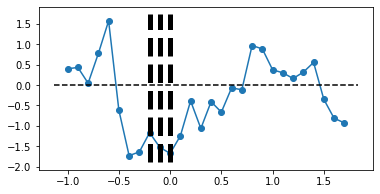

In [133]:
import pylab as plt

from scipy.stats import ttest_ind
t_theta, p = ttest_ind(psds_tms, psds_sham, axis=1)

plt.figure(figsize=(6, 3)); ax=plt.subplot(111)
X = (starttimes-500)/500
plt.plot(X, t_theta[:, 48], linestyle='-', marker='o')
plt.vlines([-0.2, -0.1, 0.0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--', linewidth=5)
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='k', linestyle='--')
